In [1]:
# estimating sample size
#based on: https://discourse.pymc.io/t/bayesian-sample-size-estimation-for-given-hpd/189/10

In [1]:
import arviz as az
import logging
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
#import pymc.sampling_jax
from scipy import stats
from scipy.stats import bernoulli

import pandas as pd
import seaborn as sns

In [2]:
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

p_true = 0.60       # hidden success rate

In [3]:
with pm.Model() as model:
    # initialized with bootstrap values
    n = pm.Data('n', 100)
    data = pm.Data('data', bernoulli.rvs(p_true, size=100).sum())    
    
    p = pm.Beta('p', alpha=2, beta=2)
    y_obs = pm.Binomial('y_obs', p=p, n=n, observed=data)
    
# Bootstrap initial p_hat
with model:
    trace = pm.sample(1000, progressbar=False, return_inferencedata=True)
    interval = az.hdi(trace, 0.05)
    interval_width = interval['p'][1] - interval['p'][0]
    summary = az.summary(trace)
    p_hat = summary["mean"]["p"]

In [4]:
sample_size = [10, 12, 15, 30]
observed_data =[bernoulli.rvs(p_hat, size=s).sum() for s in sample_size]

# Iterate over samples
interval_widths = list()
for i in range(len(sample_size)):
    with model:
        pm.set_data({'data': observed_data[i], 'n': sample_size[i]})
        trace = pm.sample(progressbar=False, return_inferencedata=True)
        
        interval = az.hdi(trace, 0.05)
        interval_width = interval['p'][1] - interval['p'][0]
        interval_widths.append(float(interval_width))

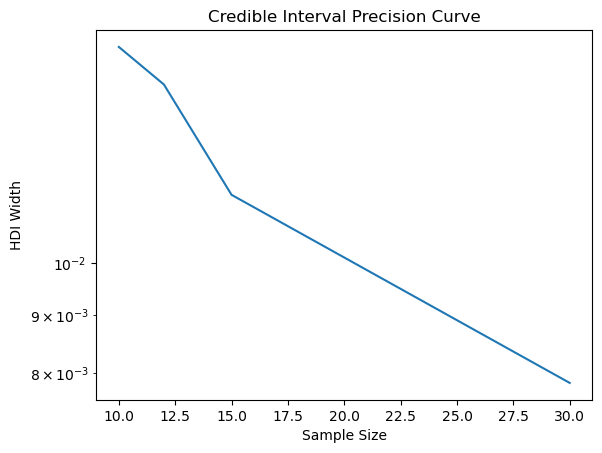

In [5]:
fig = plt.figure()
plt.plot( np.asarray(sample_size), np.asarray(interval_widths) )
plt.yscale("log")
plt.title("Credible Interval Precision Curve")
plt.ylabel("HDI Width")
plt.xlabel("Sample Size")
plt.show()

# Another option

In [2]:
# estimate sample size via power analysis
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect = 0.8
alpha = 0.05
power = 0.8
# perform power analysis
analysis = TTestIndPower()
result = analysis.solve_power(effect, power=power, nobs1=None, ratio=0.85, alpha=alpha)
print('Sample Size: %.3f' % result)


Sample Size: 27.769


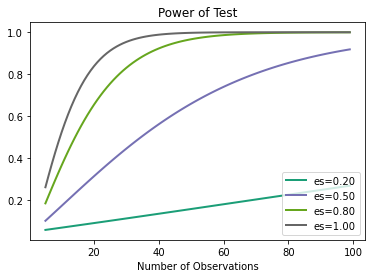

In [3]:
# calculate power curves for varying sample and effect size
from numpy import array
from matplotlib import pyplot
from statsmodels.stats.power import TTestIndPower
# parameters for power analysis
effect_sizes = array([0.2, 0.5, 0.8, 1])
sample_sizes = array(range(5, 100))
# calculate power curves from multiple power analyses
analysis = TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes,ratio=0.85, effect_size=effect_sizes)
pyplot.show()

## Simulate data
- Simulate change in ROI activation in the begining and three time points
- Test different changes between the group and the ability of model to discover based on N per group

In [2]:
# get real data, to be similar
df = pd.read_csv('amg_TraumavsNeutral.csv')

In [3]:
df[['scr_id','groupIdx','amg1','amg2','amg3']].groupby('groupIdx').describe()

amg1                                                              \
         count      mean       std       min       25%       50%       75%   
groupIdx                                                                     
0         13.0  0.091727  0.382140 -0.344641 -0.142767 -0.013621  0.221137   
1         14.0 -0.010331  0.397779 -0.760030 -0.222873  0.008892  0.309385   

                    amg2            ...                     amg3            \
               max count      mean  ...      75%       max count      mean   
groupIdx                            ...                                      
0         0.990817  12.0  0.186816  ...  0.28738  0.859317  10.0  0.151494   
1         0.533188  14.0 -0.153388  ...  0.01579  0.433613  12.0 -0.149890   

                                                                      
               std       min       25%       50%       75%       max  
groupIdx                                                              
0         0.383857 -0.246893 -0.155534  0.091739  0.288222  0.906373  
1         0.357468 -0.721853 -0.334502 -0.190697  0.153811  0.391631  

[2 rows x 24 columns]

<AxesSubplot:ylabel='Count'>

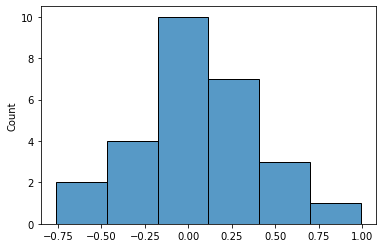

In [4]:
sns.histplot(df.amg1.values)

<AxesSubplot:ylabel='Count'>

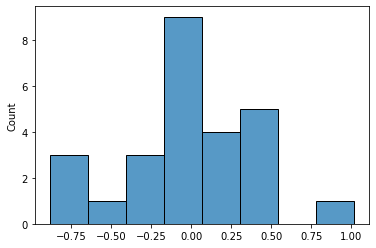

In [5]:
sns.histplot(df.amg2.values - df.amg1.values)

In [7]:
# start with one subject
def SubValue(mean=0, sd=.2):
    roi0 = np.random.normal(mean, sd)
    delta1 = np.random.normal(mean, sd)
    delta2 = np.random.normal(mean, sd)
    roi1 = roi0 + delta1
    roi2 = roi1 + delta2
    roi = [roi1,roi2]
    time = ['after', '30days']
    df = pd.DataFrame({'time':time,'roi':roi, 'roi0': roi0})
    return df

In [8]:
n = 20 # number of subjects

kpe_df = pd.DataFrame()
mid_df = pd.DataFrame()

for i in range(n):
    # keep sub index appropriate
    if i<=10:
        temp_p = SubValue()
        temp_p['sub'] = int(i)
        kpe_df = pd.concat([kpe_df, temp_p])
    else:
        temp_c = SubValue()
        temp_c['sub'] = int(i)
        mid_df = pd.concat([mid_df, temp_c])
    
sub_idxK = list(kpe_df['sub'])
sub_idxM = list(mid_df['sub'])


In [9]:
kpe_df['group'] = 1
mid_df['group'] = 0

dfAll = pd.concat([kpe_df,mid_df]).reset_index()
dfAll

,index,time,roi,roi0,sub,group
0,0,after,0.904245,0.499510,0,1
1,1,30days,1.203298,0.499510,0,1
2,0,after,0.127395,0.428729,1,1
3,1,30days,-0.086591,0.428729,1,1
4,0,after,0.215206,0.184807,2,1
5,1,30days,0.734872,0.184807,2,1
6,0,after,-0.010282,0.230137,3,1
7,1,30days,-0.261135,0.230137,3,1
8,0,after,-0.228833,0.228866,4,1
9,1,30days,-0.301573,0.228866,4,1


In [10]:
sub_idx = list(dfAll['sub'])
print(sub_idx)
n_subs = len(np.unique(dfAll['sub']))
print(n_subs)
# set time as index also
#df_long.groupIdx = pd.Categorical(df_long.groupIdx)
dfAll.variable = pd.Categorical(dfAll.roi, 
                    categories=['roi1','roi2'])
dfAll.time = pd.Categorical(dfAll.time, categories = ['after','30days'])
timeIDX = dfAll.time.cat.codes.values
print(timeIDX)
#dfAll['time'] = timeIDX

[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19]
20
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1]


/tmp/ipykernel_7126/2556596720.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,


In [14]:
with pm.Model() as hierarchical:
      
    a = pm.Normal('a', mu=0, sigma=0.1, shape=n_subs)
    cov = pm.Normal('cov', mu=0.05, sigma=0.1)
    b = pm.Normal('b', mu=0, sigma=0.1, shape=2)
    
    
   # bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=2) #
   # sigma = pm.HalfCauchy('sigma', 1)
    interact = pm.Normal('interaction', mu=0, sigma=1, shape=(2,2))
  
    # Model error
    eps = pm.HalfCauchy('eps', 1)

    y_hat = a[sub_idx] + b[timeIDX] + interact[timeIDX,dfAll.group] + cov*dfAll.roi0

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_hat,
                           sigma=eps, observed=dfAll.roi)
    
    
    # calculate differences and effect size
    diff_of_means1 = pm.Deterministic('differenceGroups end of treatment', interact[0,1] - interact[0,0])
    diff_of_means2 = pm.Deterministic('differenceGroups 30 days', interact[1,1] - interact[1,0])
   
    # effect size
    effect_size1 = pm.Deterministic('effect size2_1', 
                        diff_of_means1 / eps)
    
    effect_size2 = pm.Deterministic('effect size3_1', 
                        diff_of_means2 / eps)
    
#     effect_size3 = pm.Deterministic('effect size4_1', 
#                         abs(diff_of_means3) / eps)
    
    ppChecks = pm.sample_prior_predictive(samples = 8000)
    trace = pm.sampling_jax.sample_numpyro_nutsing_jax(draws=2000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4)

NotImplementedError: Cannot convert 0     1
1     1
2     1
3     1
4     1
5     1
6     1
7     1
8     1
9     1
10    1
11    1
12    1
13    1
14    1
15    1
16    1
17    1
18    1
19    1
20    1
21    1
22    0
23    0
24    0
25    0
26    0
27    0
28    0
29    0
30    0
31    0
32    0
33    0
34    0
35    0
36    0
37    0
38    0
39    0
Name: group, dtype: int64 to a tensor variable.

In [90]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],0.050,0.084,-0.105,0.213,0.001,0.001,16070.0,5962.0,1.0
a[1],-0.103,0.086,-0.263,0.058,0.001,0.001,13478.0,5836.0,1.0
a[2],-0.022,0.085,-0.183,0.140,0.001,0.001,15892.0,5917.0,1.0
a[3],0.055,0.084,-0.105,0.213,0.001,0.001,14520.0,5800.0,1.0
a[4],0.019,0.086,-0.143,0.183,0.001,0.001,16646.0,5699.0,1.0
a[5],0.029,0.087,-0.132,0.193,0.001,0.001,15437.0,5262.0,1.0
a[6],-0.080,0.087,-0.245,0.079,0.001,0.001,15150.0,6241.0,1.0
a[7],0.097,0.087,-0.067,0.260,0.001,0.001,16792.0,6512.0,1.0
a[8],-0.085,0.089,-0.251,0.084,0.001,0.001,15478.0,5810.0,1.0
a[9],0.058,0.086,-0.113,0.212,0.001,0.001,17050.0,6153.0,1.0


array([<AxesSubplot:title={'center':'differenceGroups end of treatment'}>,
       <AxesSubplot:title={'center':'differenceGroups 30 days'}>],
      dtype=object)

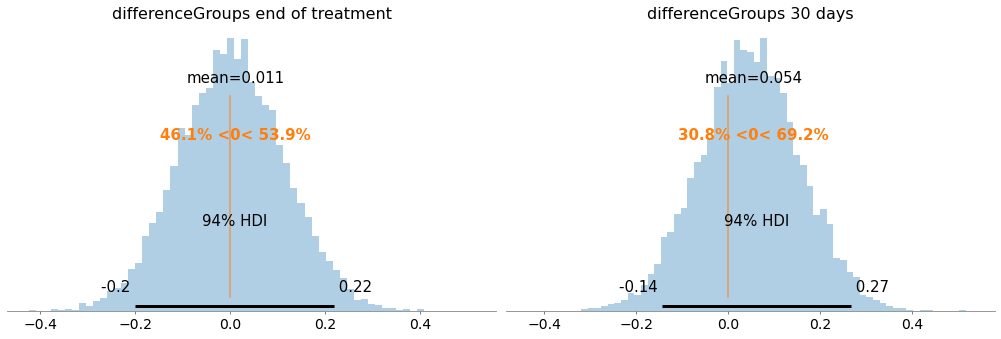

In [94]:
az.plot_posterior(trace, var_names=['differenceGroups end of treatment', 'differenceGroups 30 days'], kind='hist',
                 ref_val=0)

## now we run with difference between mean of mid and K


In [8]:
# start with one subject
def SubValue(mean=0, sd=.3, meanD1=0, sdD=.3, meanD2=0):
    roi0 = np.random.normal(mean, sd)
    delta1 = np.random.normal(meanD1, sdD)
    delta2 = np.random.normal(meanD2, sdD)
    roi1 = roi0 + delta1
    roi2 = roi1 + delta2
    roi = [roi1,roi2]
    time = ['after', '30days']
    df = pd.DataFrame({'time':time,'roi':roi, 'roi0': roi0})
    return df

In [1]:
def runModel(n):

    
    nSplit = round(0.52*n)
    kpe_df = pd.DataFrame()
    mid_df = pd.DataFrame()

    for i in range(n):
        # keep sub index appropriate
        if i<=nSplit:
            temp_p = SubValue(meanD1=-.2, sdD=.3, meanD2=0)
            temp_p['sub'] = int(i)
            kpe_df = pd.concat([kpe_df, temp_p])
        else:
            temp_c = SubValue(meanD1 = 0, sdD=.3, meanD2=0)
            temp_c['sub'] = int(i)
            mid_df = pd.concat([mid_df, temp_c])


    kpe_df['group'] = 1
    mid_df['group'] = 0

    dfAll = pd.concat([kpe_df,mid_df]).reset_index()
   
    sub_idx = list(dfAll['sub'])
  #  print(sub_idx)
    n_subs = len(np.unique(dfAll['sub']))
 #   print(n_subs)
    # set time as index also
    #df_long.groupIdx = pd.Categorical(df_long.groupIdx)
    dfAll.variable = pd.Categorical(dfAll.roi, 
                        categories=['roi1','roi2'])
    dfAll.time = pd.Categorical(dfAll.time, categories = ['after','30days'])
    timeIDX = dfAll.time.cat.codes.values
    #print(timeIDX)
    #dfAll['time'] = timeIDX

    with pm.Model() as model:

        a = pm.Normal('a', mu=0, sigma=0.1, shape=n_subs)
        cov = pm.Normal('cov', mu=0.05, sigma=0.1)
        b = pm.Normal('b', mu=0, sigma=0.1, shape=2)


       # bMed = pm.Normal('bMed', mu=0, sd=0.1, shape=2) #
       # sigma = pm.HalfCauchy('sigma', 1)
        interact = pm.Normal('interaction', mu=0, sigma=1, shape=(2,2))

        # Model error
        eps = pm.HalfCauchy('eps', 1)

        y_hat = a[sub_idx] + b[timeIDX] + interact[timeIDX,dfAll['group']] + cov*dfAll['roi0']

        # Data likelihood
        likelihood = pm.Normal('likelihood', mu=y_hat,
                               sigma=eps, observed=dfAll['roi'])


        # calculate differences and effect size
        diff_of_means1 = pm.Deterministic('differenceGroups end of treatment', interact[0,1] - interact[0,0])
        diff_of_means2 = pm.Deterministic('differenceGroups 30 days', interact[1,1] - interact[1,0])

        # effect size
        effect_size1 = pm.Deterministic('effect size2_1', 
                            diff_of_means1 / eps)

        effect_size2 = pm.Deterministic('effect size3_1', 
                            diff_of_means2 / eps)

    #     effect_size3 = pm.Deterministic('effect size4_1', 
    #                         abs(diff_of_means3) / eps)

        #ppChecks = pm.sample_prior_predictive(samples = 8000)
        trace = pm.sample(draws=2000, tune=1000, target_accept=0.9, return_inferencedata=True, cores=4, 
                          progressbar=False)
        
    return trace

In [85]:
interval_widths = list()
samples = [10, 15, 20, 25, 30, 35, 40, 60, 80]
for i in samples:
    print (i)
    trace = runModel(i)
    interval = az.hdi(trace, 0.05)
    interval_width = (interval['differenceGroups end of treatment'][1].values - interval['differenceGroups end of treatment'][0].values)
    interval_widths.append(interval_width)
#s.append(float(interval_width))

10
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9]
10
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.


15
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14]
15
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


20
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19]
20
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


25
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24]
25
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


30
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29]
30
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


35
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34]
35
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.


40
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39]
40
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 11 seconds.


60
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59, 59]
60
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.


80
[0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24, 25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33, 33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41, 42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50, 50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58, 59, 59, 60, 60, 61, 61, 62, 62, 63, 63, 64, 64, 65, 65, 66, 66, 67, 67, 68, 68, 69, 69, 70, 70, 71, 71, 72, 72, 73, 73, 74, 74, 75, 75, 76, 76, 77, 77, 78, 78, 79, 79]
80
[0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 0 1 0 1 0 1 0 1]


/tmp/ipykernel_14822/3090776702.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


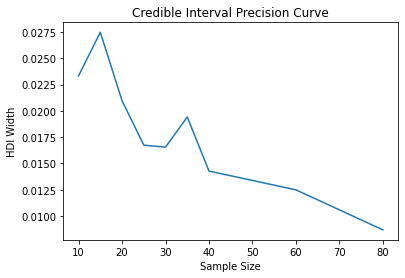

In [91]:
fig = plt.figure()
plt.plot( np.asarray(samples), np.asarray(interval_widths) )
#plt.yscale("log")
plt.title("Credible Interval Precision Curve")
plt.ylabel("HDI Width")
plt.xlabel("Sample Size")
plt.show()

In [90]:
interval_widths

[0.023335186291713328,
 0.02748621558570813,
 0.0209790593915804,
 0.01674383295694598,
 0.016553650300612274,
 0.019424395015888413,
 0.014277268891247419,
 0.012492666948426823,
 0.008678884413386961]

In [164]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.015,0.092,-0.184,0.163,0.001,0.001,12564.0,5792.0,1.0
a[1],0.042,0.095,-0.134,0.221,0.001,0.001,13417.0,5843.0,1.0
a[2],0.051,0.096,-0.126,0.233,0.001,0.001,12287.0,6333.0,1.0
a[3],-0.085,0.094,-0.259,0.096,0.001,0.001,13003.0,5867.0,1.0
a[4],0.045,0.094,-0.138,0.217,0.001,0.001,13161.0,5893.0,1.0
a[5],-0.037,0.095,-0.211,0.143,0.001,0.001,14639.0,5704.0,1.0
a[6],-0.038,0.093,-0.210,0.139,0.001,0.001,14245.0,5546.0,1.0
a[7],0.018,0.092,-0.167,0.185,0.001,0.001,14685.0,5730.0,1.0
a[8],-0.018,0.093,-0.185,0.159,0.001,0.001,13388.0,6065.0,1.0
a[9],-0.065,0.096,-0.245,0.114,0.001,0.001,14058.0,6269.0,1.0


array([<AxesSubplot:title={'center':'differenceGroups end of treatment'}>,
       <AxesSubplot:title={'center':'differenceGroups 30 days'}>],
      dtype=object)

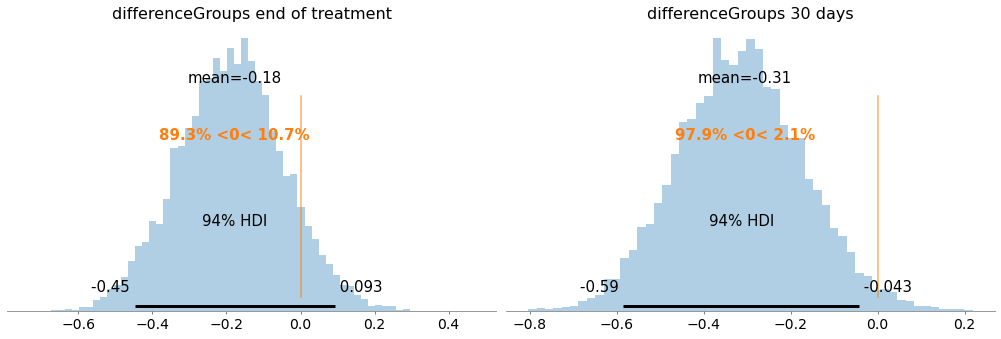

In [165]:
az.plot_posterior(trace, var_names=['differenceGroups end of treatment', 'differenceGroups 30 days'], kind='hist',
                 ref_val=0)

In [146]:
with hierarchical:
    p = pm.sample_posterior_predictive(trace)
    
#az.plot_ppc(trace)

/gpfs/ysm/project/joormann/oad4/conda_envs/neuroAnalysis/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


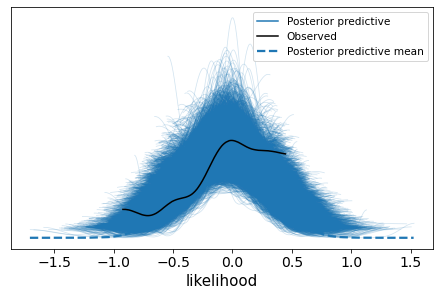

In [147]:
az.plot_ppc(az.from_pymc3(posterior_predictive=p, model=hierarchical));

## Test power not precision

In [93]:
dfAll.head()

,index,time,roi,roi0,sub,group
0,0,after,-0.421140,-0.054807,0,1
1,1,30days,-0.236025,-0.054807,0,1
2,0,after,-0.203066,0.233214,1,1
3,1,30days,-0.278663,0.233214,1,1
4,0,after,-0.793382,-0.734434,2,1


In [ ]:
allUpper = {}
samples = [20, 25, 30]
n_iter = 100

for n in samples:
    print(n)
    upperBound = list()
    for i in range(n_iter): 
        trace = runModel(n)
        interval = az.hdi(trace, 0.05)
        interval_width = interval['differenceGroups end of treatment'].values[1] # grab upper bound of 95% HDI
        upperBound.append(interval_width)
    allUpper[str(n)]=upperBound

dfPower = pd.DataFrame(allUpper)
dfPower.to_csv('powerAnalysis.csv', index=False)

20


/tmp/ipykernel_7714/492832756.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.
/tmp/ipykernel_7714/492832756.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 sec

25


/tmp/ipykernel_7714/492832756.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 seconds.
/tmp/ipykernel_7714/492832756.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 sec

30


/tmp/ipykernel_7714/492832756.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 9 seconds.
/tmp/ipykernel_7714/492832756.py:31: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  dfAll.variable = pd.Categorical(dfAll.roi,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [eps, interaction, b, cov, a]
Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 8 sec

<AxesSubplot:ylabel='Count'>

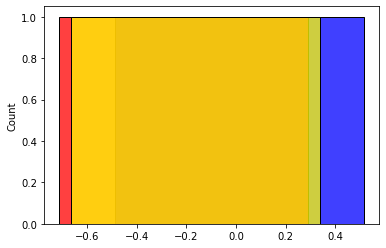

In [12]:
sns.histplot(allUpper['20'], color = 'blue')
sns.histplot(allUpper['25'], color = 'red')
sns.histplot(allUpper['30'], color = 'yellow')

In [13]:
allUpper['30']

[-0.16346846412694233]

In [14]:
pd.DataFrame(allUpper)

,20,25,30
0,0.01434,-0.210949,-0.163468


In [6]:
pw = pd.read_csv('powerAnalysis.csv')
pw

,20,25,30
0,-0.123217,-0.181683,-0.204307
1,-0.187521,-0.522031,-0.151844
2,0.134253,0.008467,-0.190006
3,-0.232763,-0.644009,-0.322594
4,0.035278,-0.399490,-0.058206
...,...,...,...
95,-0.133268,-0.353555,-0.067027
96,-0.408524,0.113088,-0.108890
97,-0.254678,-0.415905,-0.226128
98,0.029233,-0.513555,-0.232549


In [8]:
n_iter = 100

Percentage of crossing zero when N=20 is 14.000000000000002%
Percentage of crossing zero when N=25 is 9.0%
Percentage of crossing zero when N=30 is 5.0%


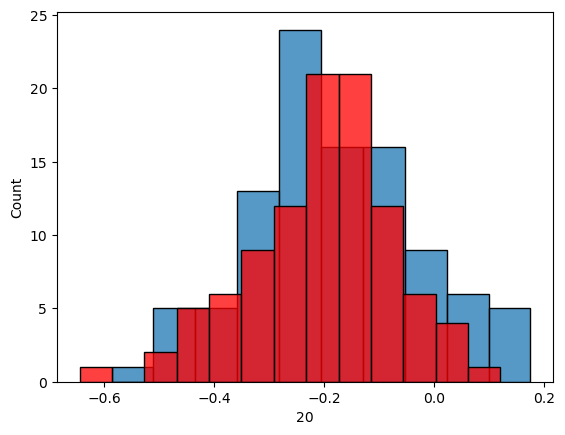

In [9]:
sns.histplot(pw['20'])
sns.histplot(pw['30'], color = 'red')
print(f"Percentage of crossing zero when N=20 is {sum(pw['20'].values>0)/n_iter*100}%")
print(f"Percentage of crossing zero when N=25 is {sum(pw['25'].values>0)/n_iter*100}%")
print(f"Percentage of crossing zero when N=30 is {sum(pw['30'].values>0)/n_iter*100}%")

In [13]:
# as Rev #2 asked - testing >0 but <.95
sum((pw['20'].values>0) & (pw['20'].values<0.95)) /n_iter

print(f"Percentage of crossing zero when N=20 is {sum((pw['20'].values>0) & (pw['20'].values<0.95))/n_iter*100}%")
print(f"Percentage of crossing zero when N=25 is {sum((pw['25'].values>0) & (pw['25'].values<0.95)) /n_iter*100}%")
print(f"Percentage of crossing zero when N=30 is {sum((pw['30'].values>0) & (pw['30'].values<0.95))/n_iter*100}%")

Percentage of crossing zero when N=20 is 14.000000000000002%
Percentage of crossing zero when N=25 is 9.0%
Percentage of crossing zero when N=30 is 5.0%


So, when the difference is .2 (i.e., effect size of .66), and N=25, the power is 91%. 
We need to test what happens when the difference is smaller.

Percentage of crossing zero when N=20 is 12.7%
Percentage of crossing zero when N=25 is 11.0%
Percentage of crossing zero when N=30 is 9.3%


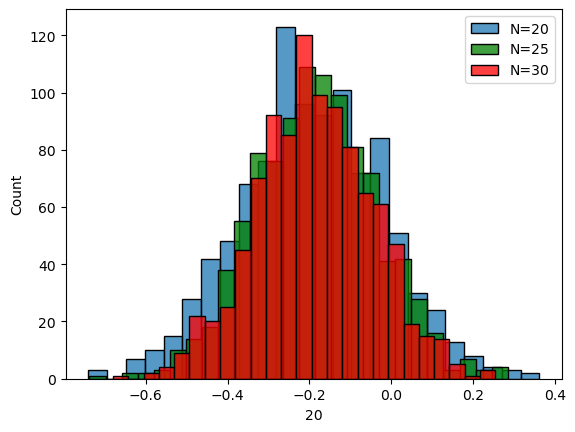

In [14]:
# grabbing 1000 iteration per N
n_iter = 1000
pw = pd.read_csv('powerAnalysis_1000_p52.csv')
sns.histplot(pw['20'], label = 'N=20')
sns.histplot(pw['25'], color = 'green', label = 'N=25')
sns.histplot(pw['30'], color = 'red', label = 'N=30')
plt.legend()
print(f"Percentage of crossing zero when N=20 is {sum((pw['20'].values>0) & (pw['20'].values<0.95))/n_iter*100}%")
print(f"Percentage of crossing zero when N=25 is {sum((pw['25'].values>0) & (pw['25'].values<0.95))/n_iter*100}%")
print(f"Percentage of crossing zero when N=30 is {sum((pw['30'].values>0) & (pw['30'].values<0.95))/n_iter*100}%")